# **Crime Hotspot Detection and Time Series Prediction**

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime, timedelta
import warnings

In [3]:
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

c:\Users\zainm\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\zainm\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\zainm\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
import json
import joblib
import os
from pathlib import Path

# Load Crime Dataset

In [8]:
df = pd.read_csv('Crimes_-_2001_to_Present_20250728.csv')

In [9]:
print(f"Dataset loaded:{len(df)} records")
print(f"Columns: {list(df.columns)} ")
print(f"Dataset shape: {df.shape}")

Dataset loaded:8366233 records
Columns: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location'] 
Dataset shape: (8366233, 22)


In [10]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13311263,JG503434,07/29/2022 03:39:00 AM,023XX S TROY ST,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,RESIDENCE,True,False,...,25.0,30.0,17,NaN,NaN,2022,04/18/2024 03:40:59 PM,NaN,NaN,NaN
1,13053066,JG103252,01/03/2023 04:44:00 PM,039XX W WASHINGTON BLVD,2017,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,True,False,...,28.0,26.0,18,NaN,NaN,2023,01/20/2024 03:41:12 PM,NaN,NaN,NaN
2,12131221,JD327000,08/10/2020 09:45:00 AM,015XX N DAMEN AVE,0326,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET,True,False,...,1.0,24.0,03,1162795.0,1909900.0,2020,05/17/2025 03:40:52 PM,41.908418,-87.677407,"(41.908417822, -87.67740693)"
3,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,13203321,JG415333,09/06/2023 05:00:00 PM,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"


In [11]:
rename_map = {
    'OFFENSE INVOLVING CHILDREN': 'Children',
    'NARCOTICS': 'Drugs',
    'ROBBERY': 'Robbery',
    'CRIM SEXUAL ASSAULT': 'Harassment',
    'CRIMINAL DAMAGE': 'Damage',
    'THEFT': 'Theft',
    'BURGLARY': 'Burglary',
    'SEX OFFENSE': 'Harassment',
    'MOTOR VEHICLE THEFT': 'VehicleTheft',
    'BATTERY': 'Battery',
    'HOMICIDE': 'Homicide',
    'CRIMINAL SEXUAL ASSAULT': 'Harassment',
    'OTHER OFFENSE': 'Other',
    'WEAPONS VIOLATION': 'Weapons',
    'DECEPTIVE PRACTICE': 'Fraud',
    'STALKING': 'Stalking',
    'CRIMINAL TRESPASS': 'Trespass',
    'ASSAULT': 'Assault',
    'PROSTITUTION': 'Prostitution',
    'KIDNAPPING': 'Kidnapping',
    'ARSON': 'Arson',
    'CONCEALED CARRY LICENSE VIOLATION': 'GunViolation',
    'INTERFERENCE WITH PUBLIC OFFICER': 'Interference',
    'PUBLIC PEACE VIOLATION': 'Public Disturbance',
    'LIQUOR LAW VIOLATION': 'Liquor',
    'INTIMIDATION': 'Threat',
    'HUMAN TRAFFICKING': 'Trafficking',
    'GAMBLING': 'Gambling',
    'OBSCENITY': 'Obscenity',
    'OTHER NARCOTIC VIOLATION': 'Narcotics',
    'NON-CRIMINAL': 'NonCriminal',
    'PUBLIC INDECENCY': 'Public Indecency',
    'RITUALISM': 'Ritualism',
    'DOMESTIC VIOLENCE': 'Domestic',
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 'NonCriminal',
    'NON - CRIMINAL': 'NonCriminal'
}

In [12]:
df['Primary Type'] = df['Primary Type'].replace(rename_map)

# Data Preprocessing - Select Required Columns Only

In [15]:
required_columns = ['Longitude', 'Latitude', 'Primary Type', 'Date']

In [16]:
df=df[required_columns].copy()

In [17]:
df = df.dropna(subset=['Primary Type', 'Latitude', 'Longitude'])

In [18]:
df = df[(df['Latitude'] >= -90) & (df['Latitude'] <= 90) &
 (df['Longitude'] >= -180) & (df['Longitude'] <= 180)]

In [19]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [20]:
df.rename(columns={'Date': 'timestamp'}, inplace=True)

In [21]:
df

,Longitude,Latitude,Primary Type,timestamp
2,-87.677407,41.908418,Robbery,2020-08-10 09:45:00
4,-87.633938,41.886018,Damage,2023-09-06 17:00:00
5,-87.626151,41.871835,Theft,2023-09-06 11:00:00
6,-87.695605,41.856547,Burglary,2019-05-21 08:20:00
7,-87.594883,41.655116,Harassment,2021-07-07 10:30:00
...,...,...,...,...
8366227,-87.569117,41.768054,Theft,2025-07-19 16:00:00
8366228,-87.689608,41.907603,Trespass,2025-07-19 08:30:00
8366229,-87.711739,41.939300,Theft,2025-07-19 16:06:00
8366231,-87.792882,41.926404,Battery,2025-07-19 16:55:00


In [22]:
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

📅 Date range: 2001-01-01 00:00:00 to 2025-07-20 00:00:00


# Add Temporal Feature

In [23]:
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['day_of_year'] = df['timestamp'].dt.dayofyear

In [24]:
df

,Longitude,Latitude,Primary Type,timestamp,date,time,hour,day_of_week,month,day_of_year
2,-87.677407,41.908418,Robbery,2020-08-10 09:45:00,2020-08-10,09:45:00,9,0,8,223
4,-87.633938,41.886018,Damage,2023-09-06 17:00:00,2023-09-06,17:00:00,17,2,9,249
5,-87.626151,41.871835,Theft,2023-09-06 11:00:00,2023-09-06,11:00:00,11,2,9,249
6,-87.695605,41.856547,Burglary,2019-05-21 08:20:00,2019-05-21,08:20:00,8,1,5,141
7,-87.594883,41.655116,Harassment,2021-07-07 10:30:00,2021-07-07,10:30:00,10,2,7,188
...,...,...,...,...,...,...,...,...,...,...
8366227,-87.569117,41.768054,Theft,2025-07-19 16:00:00,2025-07-19,16:00:00,16,5,7,200
8366228,-87.689608,41.907603,Trespass,2025-07-19 08:30:00,2025-07-19,08:30:00,8,5,7,200
8366229,-87.711739,41.939300,Theft,2025-07-19 16:06:00,2025-07-19,16:06:00,16,5,7,200
8366231,-87.792882,41.926404,Battery,2025-07-19 16:55:00,2025-07-19,16:55:00,16,5,7,200


In [25]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [26]:
df

,Longitude,Latitude,Primary Type,timestamp,date,time,hour,day_of_week,month,day_of_year,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
2,-87.677407,41.908418,Robbery,2020-08-10 09:45:00,2020-08-10,09:45:00,9,0,8,223,0.707107,-0.707107,0.000000,1.000000,-0.866025,-5.000000e-01
4,-87.633938,41.886018,Damage,2023-09-06 17:00:00,2023-09-06,17:00:00,17,2,9,249,-0.965926,-0.258819,0.974928,-0.222521,-1.000000,-1.836970e-16
5,-87.626151,41.871835,Theft,2023-09-06 11:00:00,2023-09-06,11:00:00,11,2,9,249,0.258819,-0.965926,0.974928,-0.222521,-1.000000,-1.836970e-16
6,-87.695605,41.856547,Burglary,2019-05-21 08:20:00,2019-05-21,08:20:00,8,1,5,141,0.866025,-0.500000,0.781831,0.623490,0.500000,-8.660254e-01
7,-87.594883,41.655116,Harassment,2021-07-07 10:30:00,2021-07-07,10:30:00,10,2,7,188,0.500000,-0.866025,0.974928,-0.222521,-0.500000,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8366227,-87.569117,41.768054,Theft,2025-07-19 16:00:00,2025-07-19,16:00:00,16,5,7,200,-0.866025,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01
8366228,-87.689608,41.907603,Trespass,2025-07-19 08:30:00,2025-07-19,08:30:00,8,5,7,200,0.866025,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01
8366229,-87.711739,41.939300,Theft,2025-07-19 16:06:00,2025-07-19,16:06:00,16,5,7,200,-0.866025,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01
8366231,-87.792882,41.926404,Battery,2025-07-19 16:55:00,2025-07-19,16:55:00,16,5,7,200,-0.866025,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01


In [27]:
df['time_period'] = pd.cut(df['hour'] ,
bins=[0, 6, 12, 18, 24],
labels=['Night', 'Morning', 'Afternoon', 'Evening'],include_lowest=True)

In [28]:
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [29]:
df['season'] = df['month'].map({
12: 'Winter', 1: 'Winter', 2: 'Winter',
3: 'Spring', 4: 'Spring', 5: 'Spring',
6: 'Summer', 7: 'Summer', 8: 'Summer',
9: 'Fall', 10: 'Fall', 11: 'Fall'})

In [30]:
df['category']=df['Primary Type'].str.title()

In [31]:
df['incident_id'] = range(1, len(df) + 1)

In [32]:
print("✅ Temporal features added successfully")
print(f"📊 Categories: {df['category'].nunique()} unique crime types")
print(f"🏷️ Top categories: {list(df['category'].value_counts().head().index)}")

✅ Temporal features added successfully
📊 Categories: 32 unique crime types
🏷️ Top categories: ['Theft', 'Battery', 'Damage', 'Drugs', 'Assault']


# Exploratory Data Analysis - Basic Statistics

In [33]:
print("Dataset Overview ")
print(f"Total Incidents {len(df)}")
print(f"Date Range : {df['timestamp'].min()} to  {df['timestamp'].max()}")
print(f"Time span : {df['timestamp'].max() - df['timestamp'].min()}")
print(f"Unique categories: {df['category'].nunique()}")
print(f"Geographic coverage: {df[['Latitude', 'Longitude']].drop_duplicates().shape[0]:,} unique locations")


Dataset Overview 
Total Incidents 8272953
Date Range : 2001-01-01 00:00:00 to  2025-07-20 00:00:00
Time span : 8966 days 00:00:00
Unique categories: 32
Geographic coverage: 907,612 unique locations


In [34]:
print(f"🗺️ Geographic Bounds:")
print(f"Latitude: {df['Latitude'].min():.4f} to {df['Latitude'].max():.4f}")
print(f"Longitude: {df['Longitude'].min():.4f} to {df['Longitude'].max():.4f}")

🗺️ Geographic Bounds:


Latitude: 36.6194 to 42.0229
Longitude: -91.6866 to -87.5245


In [35]:
print("📈 Top 10 Crime Categories:")
category_counts = df['category'].value_counts()
for i, (category, count) in enumerate(category_counts.head(10).items(), 1):
    percentage = (count / len(df)) * 100
    print(f"{i:2d}. {category:<20}: {count:>6,} ({percentage:5.1f}%)")


📈 Top 10 Crime Categories:
 1. Theft               : 1,753,698 ( 21.2%)
 2. Battery             : 1,517,887 ( 18.3%)
 3. Damage              : 946,698 ( 11.4%)
 4. Drugs               : 749,274 (  9.1%)
 5. Assault             : 556,576 (  6.7%)
 6. Other               : 516,760 (  6.2%)
 7. Burglary            : 440,934 (  5.3%)
 8. Vehicletheft        : 423,024 (  5.1%)
 9. Fraud               : 362,723 (  4.4%)
10. Robbery             : 311,599 (  3.8%)


In [36]:
print(f"⏰ Temporal Patterns:")
print("Peak hours:")
hourly_counts = df['hour'].value_counts().sort_index()
peak_hours = hourly_counts.nlargest(5)
for hour, count in peak_hours.items():
  percentage = (count / len(df)) * 100
  time_label = f"{hour:02d}:00"
  print(f"  {time_label}: {count:,} incidents ({percentage:.1f}%)")

print("Day of week distribution:")
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = df['day_of_week'].value_counts().sort_index()
for day_num, count in daily_counts.items():
  percentage = (count / len(df)) * 100
  print(f"  {day_names[day_num]:<10}: {count:>6,} ({percentage:5.1f}%)")

⏰ Temporal Patterns:
Peak hours:
  12:00: 471,685 incidents (5.7%)
  00:00: 469,230 incidents (5.7%)
  19:00: 464,994 incidents (5.6%)
  20:00: 462,253 incidents (5.6%)
  18:00: 452,603 incidents (5.5%)
Day of week distribution:
  Monday    : 1,170,281 ( 14.1%)
  Tuesday   : 1,179,197 ( 14.3%)
  Wednesday : 1,187,723 ( 14.4%)
  Thursday  : 1,176,007 ( 14.2%)
  Friday    : 1,241,323 ( 15.0%)
  Saturday  : 1,188,038 ( 14.4%)
  Sunday    : 1,130,384 ( 13.7%)


In [37]:
df.to_csv('preprocessed_cleaned_crime_data.csv', index=False)

# Data Visualization

In [38]:
plt.style.use('default')
fig = plt.figure(figsize = (24, 18))

<Figure size 2400x1800 with 0 Axes>

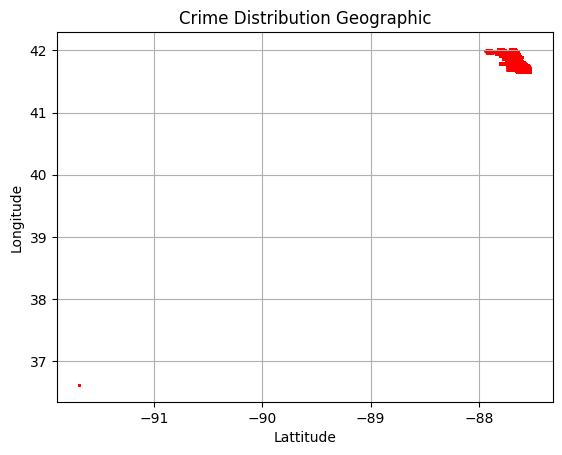

In [39]:
# Geographic Distribution
plt.scatter(df['Longitude'],df['Latitude'],alpha=0.3,s=0.5,c='red')
plt.title('Crime Distribution Geographic')
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.grid()
plt.show()

In [40]:
top_categories= df['category'].value_counts().head(8)
top_categories

category
Theft           1753698
Battery         1517887
Damage           946698
Drugs            749274
Assault          556576
Other            516760
Burglary         440934
Vehicletheft     423024
Name: count, dtype: int64

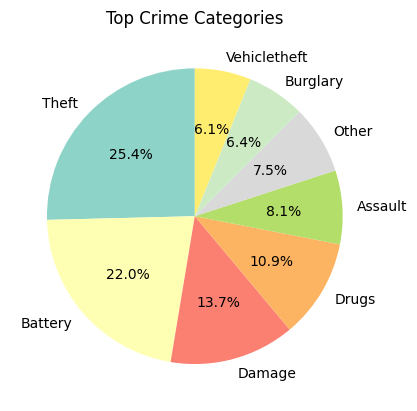

In [41]:
colors = plt.cm.Set3(np.linspace(0, 1, len(top_categories)))
plt.pie(top_categories.values, labels=top_categories.index, autopct='%1.1f%%',
colors=colors, startangle=90)
plt.title('Top Crime Categories')
plt.show()


In [42]:
hourly_counts = df['hour'].value_counts().sort_index()
hourly_counts.head()

hour
0    469230
1    264483
2    224006
3    182216
4    139356
Name: count, dtype: int64

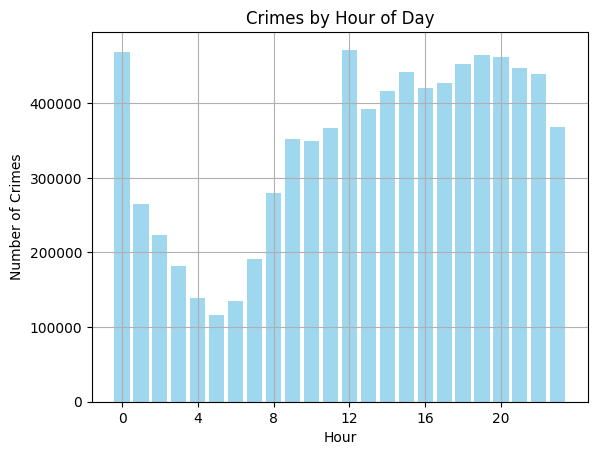

In [43]:
plt.bar(hourly_counts.index, hourly_counts.values, color='skyblue', alpha=0.8)
plt.title('Crimes by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24, 4))
plt.grid()
plt.show()


In [44]:
daily_counts = df['day_of_week'].value_counts().sort_index()
daily_counts

day_of_week
0    1170281
1    1179197
2    1187723
3    1176007
4    1241323
5    1188038
6    1130384
Name: count, dtype: int64

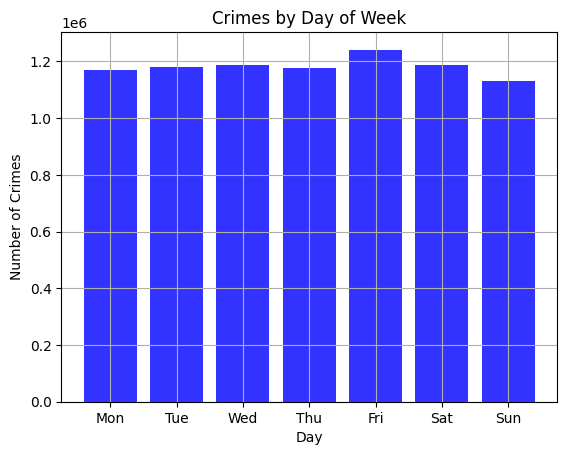

In [45]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(range(7), daily_counts.values, color='blue', alpha=0.8)
plt.xticks(range(7), day_names)
plt.title('Crimes by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()


In [46]:
monthly_counts = df['month'].value_counts().sort_index()


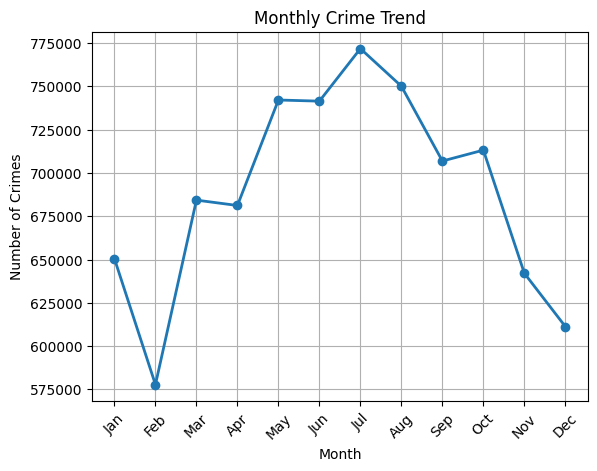

In [47]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(range(1, 13), monthly_counts.values, marker='o', linewidth=2, markersize=6)
plt.xticks(range(1, 13), month_names, rotation=45)
plt.title('Monthly Crime Trend')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid()
plt.show()


In [48]:
daily_crimes=df.groupby('date').size()

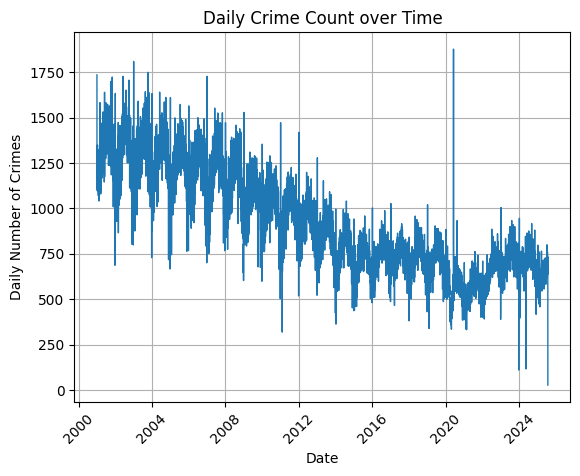

In [49]:
plt.plot(daily_crimes.index,daily_crimes.values,linewidth=1)
plt.title('Daily Crime Count over Time')
plt.xlabel('Date')
plt.ylabel('Daily Number of Crimes')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [50]:
top_3_categories = df['category'].value_counts().head(3).index

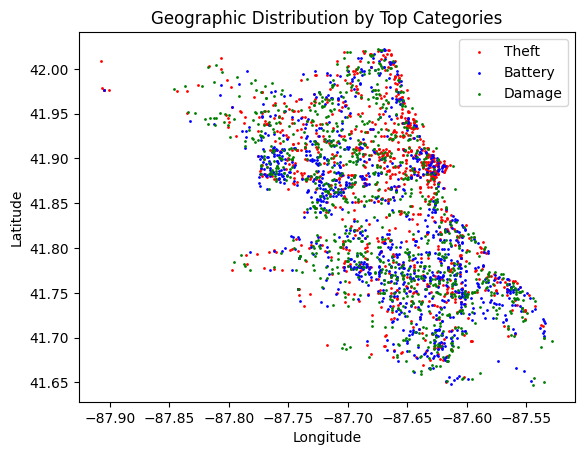

In [51]:
colors = ['red', 'blue', 'green']
for i, category in enumerate(top_3_categories):
  cat_data = df[df['category'] == category].sample(min(1000, len(df[df['category'] == category])))
  plt.scatter(cat_data['Longitude'], cat_data['Latitude'],
            s=1, label=category, c=colors[i])
plt.legend()
plt.title('Geographic Distribution by Top Categories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [52]:
seasonal_counts = df['season'].value_counts()

In [53]:
seasonal_counts

season
Summer    2263428
Spring    2107713
Fall      2062194
Winter    1839618
Name: count, dtype: int64

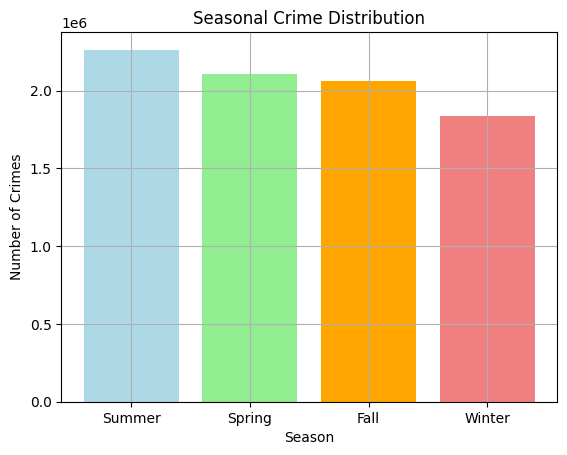

In [54]:
plt.bar(seasonal_counts.index, seasonal_counts.values,
color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
plt.title('Seasonal Crime Distribution')
plt.xlabel('Season')
plt.ylabel('Number of Crimes')
plt.grid()
plt.show()


In [55]:
df = pd.read_csv('preprocessed_cleaned_crime_data.csv')

#  Prepare Features for Clustering

In [56]:
features_df=df.copy()

In [57]:
features_df

,Longitude,Latitude,Primary Type,timestamp,date,time,hour,day_of_week,month,day_of_year,...,hour_cos,day_sin,day_cos,month_sin,month_cos,time_period,is_weekend,season,category,incident_id
0,-87.677407,41.908418,Robbery,2020-08-10 09:45:00,2020-08-10,09:45:00,9,0,8,223,...,-0.707107,0.000000,1.000000,-0.866025,-5.000000e-01,Morning,0,Summer,Robbery,1
1,-87.633938,41.886018,Damage,2023-09-06 17:00:00,2023-09-06,17:00:00,17,2,9,249,...,-0.258819,0.974928,-0.222521,-1.000000,-1.836970e-16,Afternoon,0,Fall,Damage,2
2,-87.626151,41.871835,Theft,2023-09-06 11:00:00,2023-09-06,11:00:00,11,2,9,249,...,-0.965926,0.974928,-0.222521,-1.000000,-1.836970e-16,Morning,0,Fall,Theft,3
3,-87.695605,41.856547,Burglary,2019-05-21 08:20:00,2019-05-21,08:20:00,8,1,5,141,...,-0.500000,0.781831,0.623490,0.500000,-8.660254e-01,Morning,0,Spring,Burglary,4
4,-87.594883,41.655116,Harassment,2021-07-07 10:30:00,2021-07-07,10:30:00,10,2,7,188,...,-0.866025,0.974928,-0.222521,-0.500000,-8.660254e-01,Morning,0,Summer,Harassment,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8272948,-87.569117,41.768054,Theft,2025-07-19 16:00:00,2025-07-19,16:00:00,16,5,7,200,...,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01,Afternoon,1,Summer,Theft,8272949
8272949,-87.689608,41.907603,Trespass,2025-07-19 08:30:00,2025-07-19,08:30:00,8,5,7,200,...,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01,Morning,1,Summer,Trespass,8272950
8272950,-87.711739,41.939300,Theft,2025-07-19 16:06:00,2025-07-19,16:06:00,16,5,7,200,...,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01,Afternoon,1,Summer,Theft,8272951
8272951,-87.792882,41.926404,Battery,2025-07-19 16:55:00,2025-07-19,16:55:00,16,5,7,200,...,-0.500000,-0.974928,-0.222521,-0.500000,-8.660254e-01,Afternoon,1,Summer,Battery,8272952


In [53]:
clustering_features = ['Latitude', 'Longitude', 'hour_sin', 'hour_cos',
   'day_sin', 'day_cos', 'month_sin', 'month_cos']

In [54]:
category_dummies=pd.get_dummies(features_df['category'],prefix='category')

In [55]:
features_df=pd.concat([features_df,category_dummies],axis=1)

In [56]:
clustering_features.extend(list(category_dummies.columns))

In [57]:
season_dummies = pd.get_dummies(features_df['season'], prefix='season')
features_df = pd.concat([features_df, season_dummies], axis=1)
clustering_features.extend(list(season_dummies.columns))

In [58]:
time_period_dummies = pd.get_dummies(features_df['time_period'], prefix='time_period')
features_df = pd.concat([features_df, time_period_dummies], axis=1)
clustering_features.extend(list(time_period_dummies.columns))


In [59]:
X_clustering = features_df[clustering_features].copy()

In [60]:
scaler = StandardScaler()

In [61]:
X_scaled = scaler.fit_transform(X_clustering)

In [62]:
print(f"Feature preparation complete. Feature matrix shape: {X_scaled.shape}")
print(f"Features used: {len(clustering_features)}")
print(f" Categories encoded: {len(category_dummies.columns)}")
print(f" Feature names: {clustering_features[:10]}...")

Feature preparation complete. Feature matrix shape: (374851, 36)
Features used: 36
 Categories encoded: 20
 Feature names: ['Latitude', 'Longitude', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'category_Accident', 'category_Assault']...


## DBSCAN Clustering

In [63]:
eps_range = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
min_samples_range = [3, 5, 8, 10, 15]

In [64]:
best_score=-1
best_params={}
best_model=None
best_labels=None
dbscan_results=[]

In [65]:
for eps in eps_range:
  for min_samples in min_samples_range:
    try:
     dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
     cluster_labels = dbscan.fit_predict(X_scaled)
     n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
     n_noise = list(cluster_labels).count(-1)

     if n_clusters < 2:
      continue
       # Calculate silhouette score (excluding noise points)
     mask = cluster_labels != -1
     if np.sum(mask) > 1:
       silhouette = silhouette_score(X_scaled[mask], cluster_labels[mask])
       result = {'eps': eps, 'min_samples': min_samples,'n_clusters': n_clusters,'n_noise': n_noise,
                 'noise_ratio': n_noise / len(cluster_labels),'silhouette_score': silhouette}
       dbscan_results.append(result)
       score = silhouette * (1 - result['noise_ratio'] * 0.5)
       if score > best_score:
         best_score = score
         best_params = {'eps': eps, 'min_samples': min_samples}
         best_model = dbscan
         best_labels = cluster_labels
       print(f"   eps={eps:.2f}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise, silhouette={silhouette:.3f}")

    except Exception as e:
     continue

   eps=0.05, min_samples=3: 1982 clusters, 367585 noise, silhouette=0.901
   eps=0.05, min_samples=5: 244 clusters, 373340 noise, silhouette=0.916
   eps=0.05, min_samples=8: 25 clusters, 374614 noise, silhouette=0.978
   eps=0.05, min_samples=10: 6 clusters, 374779 noise, silhouette=0.994
   eps=0.10, min_samples=3: 5193 clusters, 353944 noise, silhouette=0.819
   eps=0.10, min_samples=5: 770 clusters, 368929 noise, silhouette=0.800
   eps=0.10, min_samples=8: 179 clusters, 372841 noise, silhouette=0.825
   eps=0.10, min_samples=10: 79 clusters, 373837 noise, silhouette=0.837
   eps=0.10, min_samples=15: 6 clusters, 374746 noise, silhouette=0.968
   eps=0.15, min_samples=3: 10128 clusters, 332705 noise, silhouette=0.745
   eps=0.15, min_samples=5: 1595 clusters, 362249 noise, silhouette=0.724
   eps=0.15, min_samples=8: 427 clusters, 369715 noise, silhouette=0.726
   eps=0.15, min_samples=10: 218 clusters, 371757 noise, silhouette=0.748
   eps=0.15, min_samples=15: 58 clusters, 373807

In [66]:
if best_model is not None:
  print(f" Best DBSCAN parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}"),
  print(f"Silhouette score: {best_score:.3f}")

  dbscan_final_model = best_model
  dbscan_final_labels = best_labels
  dbscan_final_params = best_params
else:
  print("No valid DBSCAN configuration found")
  dbscan_final_model = None
  dbscan_final_labels = None
  dbscan_final_params = None

 Best DBSCAN parameters: eps=0.05, min_samples=10
Silhouette score: 0.497


In [91]:
dbscan_final_labels

array([-1, -1, -1, ..., -1, -1, -1], shape=(374851,))

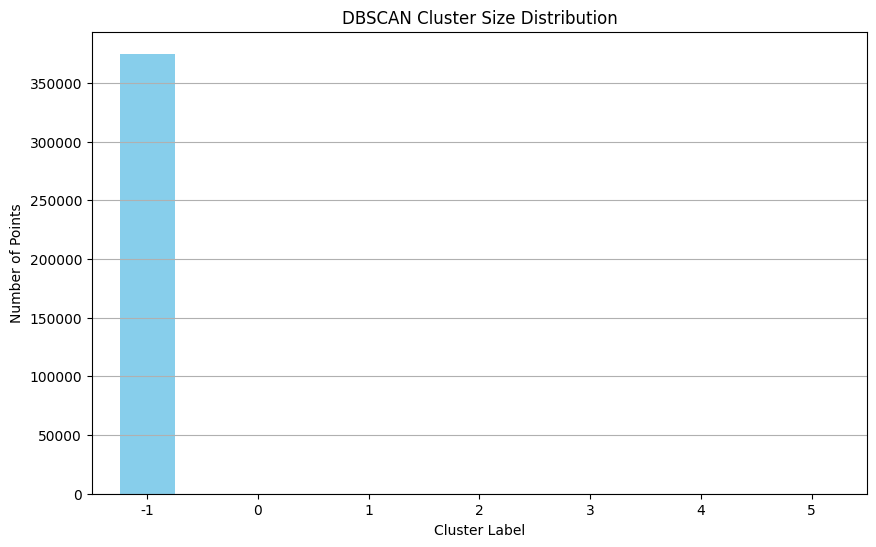

In [90]:
labels = pd.Series(dbscan_final_labels)
cluster_counts = labels.value_counts().sort_index()

plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('DBSCAN Cluster Size Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [92]:
from sklearn.decomposition import PCA

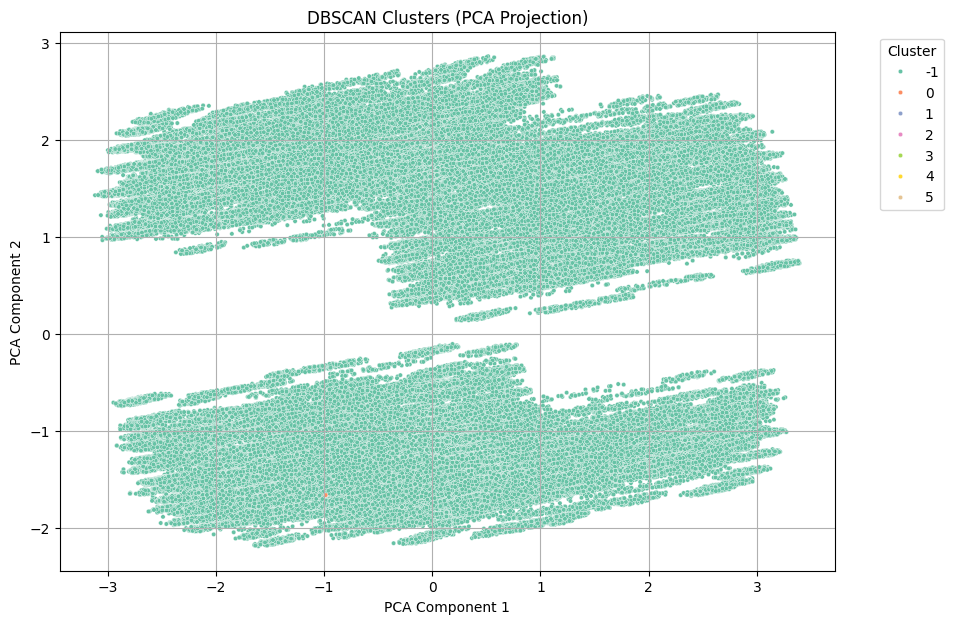

In [93]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=dbscan_final_labels,
    palette='Set2',
    s=10,
    legend='full'
)
plt.title('DBSCAN Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

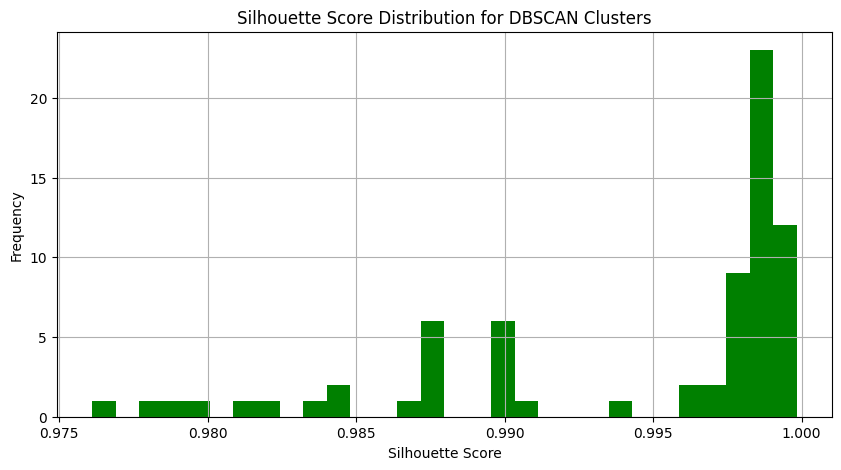

In [94]:
from sklearn.metrics import silhouette_samples

mask = dbscan_final_labels != -1
sil_samples = silhouette_samples(X_scaled[mask], np.array(dbscan_final_labels)[mask])

plt.figure(figsize=(10, 5))
plt.hist(sil_samples, bins=30, color='green')
plt.title("Silhouette Score Distribution for DBSCAN Clusters")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


##  K-means Clustering

In [67]:
k_range = range(2, 21)

In [68]:
inertias = []
silhouette_scores = []
calinski_scores = []

In [69]:
for k in k_range:
    try:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        cluster_labels = kmeans.fit_predict(X_scaled)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))

        print(f"   k={k}: inertia={kmeans.inertia_:.2f}, "
              f"silhouette={silhouette_scores[-1]:.3f}, "
              f"calinski={calinski_scores[-1]:.2f}")

    except Exception as e:
        print(f"   Error with k={k}: {e}")
        inertias.append(float('inf'))
        silhouette_scores.append(-1)
        calinski_scores.append(0)

   k=2: inertia=12665533.91, silhouette=0.080, calinski=24538.10
   k=3: inertia=11986157.88, silhouette=0.096, calinski=23587.63
   k=4: inertia=11362457.54, silhouette=0.117, calinski=23446.83


KeyboardInterrupt: 

In [70]:
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

In [71]:
optimal_k = optimal_k_silhouette

In [72]:
print(f"Optimal k by silhouette score: {optimal_k_silhouette}")
print(f"Selected k: {optimal_k}")

Optimal k by silhouette score: 4
Selected k: 4


In [73]:
kmeans_final_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
kmeans_final_labels = kmeans_final_model.fit_predict(X_scaled)
kmeans_final_params = {'k': optimal_k}

In [74]:
print(f"K-Means clustering complete with k={optimal_k}")

K-Means clustering complete with k=4


## Hierarchical Clustering

In [78]:
n_clusters_range = range(2, 21)
linkage_methods = ['ward', 'complete', 'average']

In [79]:
best_score = -1
best_params = {}
best_model = None
best_labels = None
hierarchical_results = []

In [80]:
for linkage in linkage_methods:
    for n_clusters in n_clusters_range:
        try:
            hierarchical = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage
            )
            cluster_labels = hierarchical.fit_predict(X_scaled)

            silhouette = silhouette_score(X_scaled, cluster_labels)
            calinski = calinski_harabasz_score(X_scaled, cluster_labels)
            davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)

            result = {
                'linkage': linkage,
                'n_clusters': n_clusters,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': calinski,
                'davies_bouldin_score': davies_bouldin
            }
            hierarchical_results.append(result)
            if silhouette > best_score:
                best_score = silhouette
                best_params = {'n_clusters': n_clusters, 'linkage': linkage}
                best_model = hierarchical
                best_labels = cluster_labels

            print(f"   {linkage} linkage, k={n_clusters}: silhouette={silhouette:.3f}")

        except Exception as e:
            print(f"   Error with {linkage} linkage, k={n_clusters}: {e}")
            continue


   Error with ward linkage, k=2: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=3: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=4: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=5: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=6: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=7: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=8: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linkage, k=9: Unable to allocate 523. GiB for an array with shape (70256448675,) and data type float64
   Error with ward linka

In [ ]:
if best_model is not None:
    print(f"Best Hierarchical parameters: {best_params['linkage']} linkage, k={best_params['n_clusters']}")
    print(f"   Silhouette score: {best_score:.3f}")

    hierarchical_final_model = best_model
    hierarchical_final_labels = best_labels
    hierarchical_final_params = best_params
else:
    print("No valid Hierarchical configuration found")
    hierarchical_final_model = None
    hierarchical_final_labels = None
    hierarchical_final_params = None

## Evaluate and Compare Clustering Models

In [86]:
clustering_models = {}
evaluation_results = {}

In [87]:
if dbscan_final_model is not None:
    clustering_models['DBSCAN'] = (dbscan_final_model, dbscan_final_labels, dbscan_final_params)

# if kmeans_final_model is not None:
#     clustering_models['KMeans'] = (kmeans_final_model, kmeans_final_labels, kmeans_final_params)

# if hierarchical_final_model is not None:
#     clustering_models['Hierarchical'] = (hierarchical_final_model, hierarchical_final_labels, hierarchical_final_params)

In [88]:
for model_name, (model, labels, params) in clustering_models.items():
    print(f"🔍 Evaluating {model_name}...")

    try:
        if model_name == 'DBSCAN':
            mask = labels != -1
            if np.sum(mask) <= 1:
                print(f"   ❌ {model_name}: Too few non-noise points")
                continue
            eval_X = X_scaled[mask]
            eval_labels = labels[mask]
            n_noise = np.sum(~mask)
            noise_ratio = n_noise / len(labels)
        else:
            eval_X = X_scaled
            eval_labels = labels
            n_noise = 0
            noise_ratio = 0

        # Calculate evaluation metrics
        n_clusters = len(set(eval_labels))

        if n_clusters < 2:
            print(f"   ❌ {model_name}: Less than 2 clusters")
            continue

        silhouette = silhouette_score(eval_X, eval_labels)
        calinski = calinski_harabasz_score(eval_X, eval_labels)
        davies_bouldin = davies_bouldin_score(eval_X, eval_labels)

        # Calculate additional metrics
        cluster_sizes = np.bincount(eval_labels)
        size_std = np.std(cluster_sizes)
        size_balance = 1 - (size_std / np.mean(cluster_sizes))

        # Calculate overall score
        silhouette_norm = (silhouette + 1) / 2
        calinski_norm = min(calinski / 1000, 1)
        davies_bouldin_norm = max(0, 1 - davies_bouldin / 5)
        noise_penalty = 1 - noise_ratio

        overall_score = (
            0.4 * silhouette_norm +
            0.3 * calinski_norm +
            0.2 * davies_bouldin_norm +
            0.1 * noise_penalty
        )

        evaluation_results[model_name] = {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'davies_bouldin_score': davies_bouldin,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'cluster_size_balance': size_balance,
            'parameters': params,
            'overall_score': overall_score
        }

        print(f"{model_name}: Silhouette={silhouette:.3f}, "
              f"Calinski={calinski:.2f}, Davies-Bouldin={davies_bouldin:.3f}")

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        continue

🔍 Evaluating DBSCAN...
DBSCAN: Silhouette=0.994, Calinski=784352.57, Davies-Bouldin=0.010


In [89]:
if evaluation_results:
    best_clustering_model = max(evaluation_results.keys(),
                               key=lambda x: evaluation_results[x]['overall_score'])

    print(f"Best clustering model: {best_clustering_model}")
    print(f"   Overall score: {evaluation_results[best_clustering_model]['overall_score']:.3f}")

    print(f"📈 Model Comparison:")
    print(f"{'Model':<12} {'Silhouette':<11} {'Calinski':<10} {'Davies-B':<9} {'Clusters':<9} {'Overall':<8}")
    print("-" * 70)

    for name, metrics in sorted(evaluation_results.items(), key=lambda x: x[1]['overall_score'], reverse=True):
        print(f"{name:<12} {metrics['silhouette_score']:<11.3f} {metrics['calinski_harabasz_score']:<10.2f} "
              f"{metrics['davies_bouldin_score']:<9.3f} {metrics['n_clusters']:<9} {metrics['overall_score']:<8.3f}")
else:
    print("No valid clustering results to evaluate")
    best_clustering_model = None

Best clustering model: DBSCAN
   Overall score: 0.898
📈 Model Comparison:
Model        Silhouette  Calinski   Davies-B  Clusters  Overall 
----------------------------------------------------------------------
DBSCAN       0.994       784352.57  0.010     6         0.898   


# Hotspot Detection - Progressive Clustering Approach

In [95]:
print("=" * 50)

In [96]:
radius_km = 1.0
min_cluster_size = 3
hotspot_threshold = 10

In [97]:
print(f"Analyzing {len(df)} incidents")
print(f"Cluster threshold: {min_cluster_size} incidents")
print(f"Hotspot threshold: {hotspot_threshold} incidents")
print(f"Geographic radius: {radius_km} km")

Analyzing 374851 incidents
Cluster threshold: 3 incidents
Hotspot threshold: 10 incidents
Geographic radius: 1.0 km


In [98]:
clusters = []
hotspots = []
cluster_id = 0

In [99]:
categories_to_process = df['category'].unique()

In [100]:
for category in categories_to_process:
    print(f"\n🏷️ Processing category: {category}")

    category_data = df[df['category'] == category].copy()

    if len(category_data) < min_cluster_size:
        print(f"   ⚠️ Insufficient data ({len(category_data)} incidents)")
        continue

    coords = category_data[['Latitude', 'Longitude']].values

    # 1 degree ≈ 111 km at equator
    eps_degrees = radius_km / 111.0

    dbscan = DBSCAN(eps=eps_degrees, min_samples=min_cluster_size)
    cluster_labels = dbscan.fit_predict(coords)

    # Process each cluster
    unique_labels = set(cluster_labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    print(f"   📊 Found {len(unique_labels)} clusters")

    for cluster_label in unique_labels:
        cluster_data = category_data[cluster_labels == cluster_label].copy()
        incident_count = len(cluster_data)

        if incident_count >= min_cluster_size:
            # Calculate geographic centroid
            centroid_lat = cluster_data['Latitude'].mean()
            centroid_lng = cluster_data['Longitude'].mean()

            # Calculate actual radius (maximum distance from centroid)
            max_distance = 0
            centroid = (centroid_lat, centroid_lng)
            for _, incident in cluster_data.iterrows():
                incident_point = (incident['Latitude'], incident['Longitude'])
                distance = geodesic(centroid, incident_point).kilometers
                max_distance = max(max_distance, distance)

            # Temporal analysis
            hour_counts = cluster_data['hour'].value_counts()
            peak_hour = hour_counts.index[0] if len(hour_counts) > 0 else 0
            peak_hour_count = hour_counts.iloc[0] if len(hour_counts) > 0 else 0
            peak_hour_percentage = (peak_hour_count / len(cluster_data)) * 100

            dow_counts = cluster_data['day_of_week'].value_counts()
            peak_day = dow_counts.index[0] if len(dow_counts) > 0 else 0
            peak_day_count = dow_counts.iloc[0] if len(dow_counts) > 0 else 0
            peak_day_percentage = (peak_day_count / len(cluster_data)) * 100

            month_counts = cluster_data['month'].value_counts()
            peak_month = month_counts.index[0] if len(month_counts) > 0 else 1

            # Time concentration
            time_span_days = (cluster_data['timestamp'].max() - cluster_data['timestamp'].min()).days
            time_concentration = len(cluster_data) / max(time_span_days, 1)

            # Recent activity (last 30 days)
            recent_cutoff = datetime.now() - timedelta(days=30)
            recent_incidents = len(cluster_data[cluster_data['timestamp'] > recent_cutoff])

            # Risk assessment
            incident_score = min(len(cluster_data) / 20, 1.0) * 40
            recency_score = (recent_incidents / len(cluster_data)) * 30 if len(cluster_data) > 0 else 0
            concentration_score = min(len(cluster_data) / max(time_span_days, 1), 1.0) * 20

            # Category severity score
            severity_mapping = {
                'Violence': 10, 'Robbery': 9, 'Theft': 6, 'Vandalism': 4, 'Fraud': 3, 'Accident': 5
            }
            severity_score = severity_mapping.get(category, 5)

            risk_score = min(incident_score + recency_score + concentration_score + severity_score, 100)

            # Growth potential analysis
            cluster_data_sorted = cluster_data.sort_values('timestamp')
            if len(cluster_data_sorted) >= 4:
                mid_point = len(cluster_data_sorted) // 2
                first_half = cluster_data_sorted.iloc[:mid_point]
                second_half = cluster_data_sorted.iloc[mid_point:]

                if len(first_half) > 0 and len(second_half) > 0:
                    first_half_days = (first_half['timestamp'].max() - first_half['timestamp'].min()).days
                    second_half_days = (second_half['timestamp'].max() - second_half['timestamp'].min()).days

                    first_rate = len(first_half) / max(first_half_days, 1)
                    second_rate = len(second_half) / max(second_half_days, 1)

                    if second_rate > first_rate * 1.5:
                        growth_potential = 'High'
                    elif second_rate > first_rate * 1.1:
                        growth_potential = 'Medium'
                    elif second_rate < first_rate * 0.7:
                        growth_potential = 'Declining'
                    else:
                        growth_potential = 'Stable'
                else:
                    growth_potential = 'Unknown'
            else:
                growth_potential = 'Unknown'

            # Determine risk level
            if incident_count >= hotspot_threshold * 2 or risk_score >= 90:
                risk_level = 'Critical'
            elif incident_count >= hotspot_threshold or risk_score >= 70:
                risk_level = 'High'
            elif incident_count >= hotspot_threshold * 0.7 or risk_score >= 50:
                risk_level = 'Medium'
            else:
                risk_level = 'Low'

            # Create cluster/hotspot object
            cluster_obj = {
                'cluster_id': cluster_id,
                'category': category,
                'centroid_lat': centroid_lat,
                'centroid_lng': centroid_lng,
                'incident_count': incident_count,
                'actual_radius_km': max_distance,
                'incident_ids': cluster_data['incident_id'].tolist(),
                'is_hotspot': incident_count >= hotspot_threshold,
                'risk_level': risk_level,
                'risk_score': risk_score,
                'growth_potential': growth_potential,
                'created_date': datetime.now().isoformat(),
                'peak_hour': int(peak_hour),
                'peak_hour_percentage': round(peak_hour_percentage, 1),
                'peak_day_of_week': int(peak_day),
                'peak_day_percentage': round(peak_day_percentage, 1),
                'peak_month': int(peak_month),
                'time_concentration': round(time_concentration, 2),
                'recent_incidents_30d': recent_incidents,
                'activity_trend': 'increasing' if recent_incidents > len(cluster_data) * 0.3 else 'stable'
            }

            # Classify as hotspot or cluster
            if incident_count >= hotspot_threshold:
                hotspots.append(cluster_obj)
                print(f"   🔥 HOTSPOT {cluster_id}: {incident_count} incidents (Risk: {risk_score:.1f})")
            else:
                clusters.append(cluster_obj)
                print(f"   🎯 CLUSTER {cluster_id}: {incident_count} incidents (Risk: {risk_score:.1f})")

            cluster_id += 1


🏷️ Processing category: Battery
   📊 Found 6 clusters
   🔥 HOTSPOT 0: 68688 incidents (Risk: 66.0)
   🔥 HOTSPOT 1: 20 incidents (Risk: 45.9)
   🔥 HOTSPOT 2: 192 incidents (Risk: 52.6)
   🔥 HOTSPOT 3: 178 incidents (Risk: 52.4)
   🔥 HOTSPOT 4: 12 incidents (Risk: 29.5)
   🎯 CLUSTER 5: 5 incidents (Risk: 15.2)

🏷️ Processing category: Weapons
   📊 Found 8 clusters
   🔥 HOTSPOT 6: 10993 incidents (Risk: 66.0)
   🎯 CLUSTER 7: 4 incidents (Risk: 13.4)
   🔥 HOTSPOT 8: 33 incidents (Risk: 48.0)
   🔥 HOTSPOT 9: 19 incidents (Risk: 43.8)
   🎯 CLUSTER 10: 5 incidents (Risk: 15.5)
   🎯 CLUSTER 11: 4 incidents (Risk: 13.3)
   🎯 CLUSTER 12: 3 incidents (Risk: 11.2)
   🎯 CLUSTER 13: 3 incidents (Risk: 11.2)

🏷️ Processing category: Damage
   📊 Found 6 clusters
   🔥 HOTSPOT 14: 42164 incidents (Risk: 66.0)
   🔥 HOTSPOT 15: 44 incidents (Risk: 46.6)
   🔥 HOTSPOT 16: 12 incidents (Risk: 29.5)
   🔥 HOTSPOT 17: 33 incidents (Risk: 46.4)
   🎯 CLUSTER 18: 5 incidents (Risk: 15.8)
   🎯 CLUSTER 19: 3 incide

In [101]:
print(f"\n✅ DETECTION COMPLETE")
print(f"🔥 Hotspots detected: {len(hotspots)}")
print(f"🎯 Clusters detected: {len(clusters)}")


✅ DETECTION COMPLETE
🔥 Hotspots detected: 94
🎯 Clusters detected: 192


In [102]:
if hotspots:
    print(f"\n🔥 Top 5 Hotspots by Risk Score:")
    sorted_hotspots = sorted(hotspots, key=lambda x: x['risk_score'], reverse=True)
    for i, hotspot in enumerate(sorted_hotspots[:5], 1):
        print(f"{i}. {hotspot['category']} - Risk: {hotspot['risk_score']:.1f} - "
              f"Incidents: {hotspot['incident_count']} - Location: ({hotspot['centroid_lat']:.4f}, {hotspot['centroid_lng']:.4f})")


🔥 Top 5 Hotspots by Risk Score:
1. Robbery - Risk: 69.8 - Incidents: 12309 - Location: (41.8447, -87.6682)
2. Theft - Risk: 66.9 - Incidents: 89484 - Location: (41.8653, -87.6649)
3. Burglary - Risk: 66.2 - Incidents: 12958 - Location: (41.8550, -87.6680)
4. Public Disturbance - Risk: 66.2 - Incidents: 1281 - Location: (41.8551, -87.6644)
5. Drugs - Risk: 66.0 - Incidents: 10229 - Location: (41.8575, -87.6933)


#  Time Series Data Preparation

In [58]:
df['date_only'] = df['timestamp'].dt.date

AttributeError: Can only use .dt accessor with datetimelike values

In [104]:
daily_counts = df.groupby('date_only').size().reset_index(name='incident_count')

In [105]:
daily_counts['date_only'] = pd.to_datetime(daily_counts['date_only'])

In [106]:
daily_counts = daily_counts.set_index('date_only')

In [107]:
date_range = pd.date_range(start=daily_counts.index.min(),
                           end=daily_counts.index.max(),
                           freq='D')

In [108]:
daily_counts = daily_counts.reindex(date_range, fill_value=0)

In [109]:
daily_counts['day_of_week'] = daily_counts.index.dayofweek
daily_counts['month'] = daily_counts.index.month
daily_counts['day_of_year'] = daily_counts.index.dayofyear
daily_counts['is_weekend'] = daily_counts.index.dayofweek.isin([5, 6]).astype(int)

In [110]:
for lag in [1, 2, 3, 7]:
    daily_counts[f'incident_count_lag_{lag}'] = daily_counts['incident_count'].shift(lag)


In [111]:
for window in [3, 7, 14]:
    daily_counts[f'incident_count_rolling_mean_{window}'] = (
        daily_counts['incident_count'].rolling(window=window).mean()
    )

In [112]:
daily_counts['trend'] = range(len(daily_counts))

In [113]:
print(f"✅ Time series data prepared: {len(daily_counts)} days")
print(f"📅 Date range: {daily_counts.index.min()} to {daily_counts.index.max()}")
print(f"📊 Average daily incidents: {daily_counts['incident_count'].mean():.2f}")

✅ Time series data prepared: 567 days
📅 Date range: 2024-01-01 00:00:00 to 2025-07-20 00:00:00
📊 Average daily incidents: 661.11


In [114]:
daily_counts.head()

,incident_count,day_of_week,month,day_of_year,is_weekend,incident_count_lag_1,incident_count_lag_2,incident_count_lag_3,incident_count_lag_7,incident_count_rolling_mean_3,incident_count_rolling_mean_7,incident_count_rolling_mean_14,trend
2024-01-01,933,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2024-01-02,633,1,1,2,0,933.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2024-01-03,652,2,1,3,0,633.0,933.0,NaN,NaN,739.333333,NaN,NaN,2
2024-01-04,675,3,1,4,0,652.0,633.0,933.0,NaN,653.333333,NaN,NaN,3
2024-01-05,656,4,1,5,0,675.0,652.0,633.0,NaN,661.000000,NaN,NaN,4


# ARIMA Time Series Model

In [115]:
y = daily_counts['incident_count'].dropna()

In [116]:
if len(y) >= 50:
    try:
        # Simple ARIMA(1,1,1) for demonstration
        arima_model = ARIMA(y, order=(1, 1, 1))
        arima_fitted = arima_model.fit()

        # Generate forecasts
        forecast_steps = min(30, len(y) // 4)
        arima_forecast = arima_fitted.forecast(steps=forecast_steps)

        # Calculate metrics
        arima_fitted_values = arima_fitted.fittedvalues

        # Align fitted values with original data
        if len(arima_fitted_values) < len(y):
            y_aligned = y[len(y) - len(arima_fitted_values):]
        else:
            y_aligned = y
            arima_fitted_values = arima_fitted_values[:len(y)]

        arima_mse = mean_squared_error(y_aligned, arima_fitted_values)
        arima_mae = mean_absolute_error(y_aligned, arima_fitted_values)
        arima_rmse = np.sqrt(arima_mse)

        print(f"✅ ARIMA model fitted successfully")
        print(f"   AIC: {arima_fitted.aic:.2f}")
        print(f"   RMSE: {arima_rmse:.3f}")
        print(f"   MAE: {arima_mae:.3f}")

        arima_results = {
            'model': arima_fitted,
            'forecast': arima_forecast,
            'rmse': arima_rmse,
            'mae': arima_mae,
            'mse': arima_mse
        }

    except Exception as e:
        print(f"❌ ARIMA model failed: {e}")
        arima_results = None
else:
    print("❌ Insufficient data for ARIMA modeling")
    arima_results = None


✅ ARIMA model fitted successfully
   AIC: 6294.91
   RMSE: 74.087
   MAE: 42.070


# Random Forest Time Series Model

In [117]:
feature_cols = [col for col in daily_counts.columns if col != 'incident_count']

In [118]:
clean_data = daily_counts.dropna()

In [119]:
if len(clean_data) >= 50:
    X = clean_data[feature_cols]
    y = clean_data['incident_count']

    # Time series split (preserve temporal order)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    try:
        # Fit Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)

        # Make predictions
        rf_pred = rf_model.predict(X_test)
        rf_train_pred = rf_model.predict(X_train)

        # Calculate metrics
        rf_test_mse = mean_squared_error(y_test, rf_pred)
        rf_test_mae = mean_absolute_error(y_test, rf_pred)
        rf_test_r2 = r2_score(y_test, rf_pred)
        rf_test_rmse = np.sqrt(rf_test_mse)

        rf_train_mse = mean_squared_error(y_train, rf_train_pred)
        rf_train_rmse = np.sqrt(rf_train_mse)

        print(f"✅ Random Forest model fitted successfully")
        print(f"   Test RMSE: {rf_test_rmse:.3f}")
        print(f"   Test MAE: {rf_test_mae:.3f}")
        print(f"   Test R²: {rf_test_r2:.3f}")

        # Feature importance
        feature_importance = dict(zip(feature_cols, rf_model.feature_importances_))
        top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"   Top 5 features: {[f[0] for f in top_features]}")

        rf_results = {
            'model': rf_model,
            'predictions': rf_pred,
            'rmse': rf_test_rmse,
            'mae': rf_test_mae,
            'r2': rf_test_r2,
            'mse': rf_test_mse,
            'feature_importance': feature_importance
        }

    except Exception as e:
        print(f"❌ Random Forest model failed: {e}")
        rf_results = None
else:
    print("❌ Insufficient data for Random Forest modeling")
    rf_results = None

✅ Random Forest model fitted successfully
   Test RMSE: 48.315
   Test MAE: 21.234
   Test R²: 0.569
   Top 5 features: ['incident_count_rolling_mean_3', 'incident_count_lag_2', 'incident_count_lag_1', 'incident_count_lag_3', 'incident_count_rolling_mean_7']


# Linear Regression Time Series Model

In [120]:
if len(clean_data) >= 50:
    try:
        # Fit Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)

        # Make predictions
        lr_pred = lr_model.predict(X_test)
        lr_train_pred = lr_model.predict(X_train)

        # Calculate metrics
        lr_test_mse = mean_squared_error(y_test, lr_pred)
        lr_test_mae = mean_absolute_error(y_test, lr_pred)
        lr_test_r2 = r2_score(y_test, lr_pred)
        lr_test_rmse = np.sqrt(lr_test_mse)

        print(f"✅ Linear Regression model fitted successfully")
        print(f"   Test RMSE: {lr_test_rmse:.3f}")
        print(f"   Test MAE: {lr_test_mae:.3f}")
        print(f"   Test R²: {lr_test_r2:.3f}")

        lr_results = {
            'model': lr_model,
            'predictions': lr_pred,
            'rmse': lr_test_rmse,
            'mae': lr_test_mae,
            'r2': lr_test_r2,
            'mse': lr_test_mse
        }

    except Exception as e:
        print(f"❌ Linear Regression model failed: {e}")
        lr_results = None
else:
    print("❌ Insufficient data for Linear Regression modeling")
    lr_results = None

✅ Linear Regression model fitted successfully
   Test RMSE: 0.000
   Test MAE: 0.000
   Test R²: 1.000


# LSTM Deep Learning Model

In [121]:
lookback_days = 30
forecast_days = 7

In [122]:
data = daily_counts['incident_count'].values

In [123]:
if len(data) >= lookback_days + forecast_days + 50:
    try:
        from sklearn.preprocessing import MinMaxScaler

        # Normalize data
        lstm_scaler = MinMaxScaler()
        data_scaled = lstm_scaler.fit_transform(data.reshape(-1, 1)).flatten()

        # Create sequences
        X_lstm, y_lstm = [], []
        for i in range(lookback_days, len(data_scaled) - forecast_days + 1):
            X_lstm.append(data_scaled[i-lookback_days:i])
            y_lstm.append(data_scaled[i:i+forecast_days])

        X_lstm = np.array(X_lstm)
        y_lstm = np.array(y_lstm)

        if len(X_lstm) >= 20:
            # Reshape for LSTM
            X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

            # Split data
            split_idx = int(len(X_lstm) * 0.8)
            X_lstm_train, X_lstm_test = X_lstm[:split_idx], X_lstm[split_idx:]
            y_lstm_train, y_lstm_test = y_lstm[:split_idx], y_lstm[split_idx:]

            # Build LSTM model
            lstm_model = Sequential([
                LSTM(50, return_sequences=True, input_shape=(X_lstm_train.shape[1], 1)),
                Dropout(0.2),
                LSTM(50, return_sequences=False),
                Dropout(0.2),
                Dense(25),
                Dense(forecast_days)
            ])

            lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

            # Train model
            history = lstm_model.fit(
                X_lstm_train, y_lstm_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_lstm_test, y_lstm_test),
                verbose=0
            )

            # Make predictions
            lstm_pred = lstm_model.predict(X_lstm_test, verbose=0)

            # Calculate metrics
            lstm_test_mse = mean_squared_error(y_lstm_test.flatten(), lstm_pred.flatten())
            lstm_test_mae = mean_absolute_error(y_lstm_test.flatten(), lstm_pred.flatten())
            lstm_test_rmse = np.sqrt(lstm_test_mse)

            print(f"✅ LSTM model fitted successfully")
            print(f"   Test RMSE: {lstm_test_rmse:.3f}")
            print(f"   Test MAE: {lstm_test_mae:.3f}")

            lstm_results = {
                'model': lstm_model,
                'scaler': lstm_scaler,
                'predictions': lstm_pred,
                'rmse': lstm_test_rmse,
                'mae': lstm_test_mae,
                'mse': lstm_test_mse,
                'history': history
            }
        else:
            print("❌ Insufficient sequences for LSTM")
            lstm_results = None

    except Exception as e:
        print(f"❌ LSTM model failed: {e}")
        lstm_results = None
else:
    print("❌ Insufficient data for LSTM modeling")
    lstm_results = None

C:\Users\zainm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ LSTM model fitted successfully
   Test RMSE: 0.053
   Test MAE: 0.039


# Compare Time Series Models

In [124]:
ts_models = {}
ts_evaluation = {}

In [125]:
if 'arima_results' in locals() and arima_results is not None:
    ts_models['ARIMA'] = arima_results
    ts_evaluation['ARIMA'] = {
        'rmse': arima_results['rmse'],
        'mae': arima_results['mae'],
        'r2': 'N/A'
    }

In [126]:
if 'rf_results' in locals() and rf_results is not None:
    ts_models['RandomForest'] = rf_results
    ts_evaluation['RandomForest'] = {
        'rmse': rf_results['rmse'],
        'mae': rf_results['mae'],
        'r2': rf_results['r2']
    }

In [127]:
if 'lr_results' in locals() and lr_results is not None:
    ts_models['LinearRegression'] = lr_results
    ts_evaluation['LinearRegression'] = {
        'rmse': lr_results['rmse'],
        'mae': lr_results['mae'],
        'r2': lr_results['r2']
    }

In [128]:
if 'lstm_results' in locals() and lstm_results is not None:
    ts_models['LSTM'] = lstm_results
    ts_evaluation['LSTM'] = {
        'rmse': lstm_results['rmse'],
        'mae': lstm_results['mae'],
        'r2': 'N/A'
    }

In [129]:
if ts_evaluation:
    # Find best model based on RMSE
    best_ts_model = min(ts_evaluation.keys(), key=lambda x: ts_evaluation[x]['rmse'])

    print(f"\n🏆 Best time series model: {best_ts_model}")
    print(f"   RMSE: {ts_evaluation[best_ts_model]['rmse']:.3f}")

    # Print comparison table
    print(f"\n📈 Time Series Model Comparison:")
    print(f"{'Model':<15} {'RMSE':<8} {'MAE':<8} {'R²':<8}")
    print("-" * 45)

    for name, metrics in sorted(ts_evaluation.items(), key=lambda x: x[1]['rmse']):
        r2_str = f"{metrics['r2']:.3f}" if metrics['r2'] != 'N/A' else "N/A"
        print(f"{name:<15} {metrics['rmse']:<8.3f} {metrics['mae']:<8.3f} {r2_str:<8}")
else:
    print("❌ No successful time series models to compare")
    best_ts_model = None



🏆 Best time series model: LinearRegression
   RMSE: 0.000

📈 Time Series Model Comparison:
Model           RMSE     MAE      R²      
---------------------------------------------
LinearRegression 0.000    0.000    1.000   
LSTM            0.053    0.039    N/A     
RandomForest    48.315   21.234   0.569   
ARIMA           74.087   42.070   N/A     


# Save All Models

In [130]:
os.makedirs('saved_models', exist_ok=True)
os.makedirs('saved_models/clustering', exist_ok=True)
os.makedirs('saved_models/time_series', exist_ok=True)

In [131]:
if 'clustering_models' in locals():
    for model_name, (model, labels, params) in clustering_models.items():
        try:
            model_path = f"saved_models/clustering/{model_name.lower()}_model.joblib"
            joblib.dump({
                'model': model,
                'labels': labels,
                'parameters': params,
                'scaler': scaler
            }, model_path)
            print(f"✅ Saved {model_name} clustering model")
        except Exception as e:
            print(f"❌ Error saving {model_name}: {e}")


✅ Saved DBSCAN clustering model


In [133]:
if 'ts_models' in locals():
    for model_name, result in ts_models.items():
        try:
            if model_name == 'LSTM':
                # Save Keras model separately
                model_path = f"saved_models/time_series/{model_name.lower()}_model.keras"
                result['model'].save(model_path)
                # Save other components
                joblib.dump({
                    'scaler': result['scaler'],
                    'metrics': {
                        'rmse': result['rmse'],
                        'mae': result['mae'],
                        'mse': result['mse']
                    }
                }, f"{model_path}_components.joblib")
            else:
                model_path = f"saved_models/time_series/{model_name.lower()}_model.joblib"
                joblib.dump(result, model_path)

            print(f"✅ Saved {model_name} time series model")
        except Exception as e:
            print(f"❌ Error saving {model_name}: {e}")


✅ Saved ARIMA time series model
✅ Saved RandomForest time series model
✅ Saved LinearRegression time series model
✅ Saved LSTM time series model


In [134]:
if 'scaler' in locals():
    joblib.dump(scaler, 'saved_models/feature_scaler.joblib')
    print("✅ Saved feature scaler")

print("🎯 Model saving complete!")

✅ Saved feature scaler
🎯 Model saving complete!


# Save Hotspots and Clusters in JSON Format

In [135]:
os.makedirs('json_exports', exist_ok=True)

In [136]:
if hotspots:
    hotspots_export = []
    for hotspot in hotspots:
        hotspot_data = {
            'id': hotspot['cluster_id'],
            'category': hotspot['category'],
            'latitude': hotspot['centroid_lat'],
            'longitude': hotspot['centroid_lng'],
            'incidentCount': hotspot['incident_count'],
            'riskScore': round(hotspot['risk_score'], 1),
            'riskLevel': hotspot['risk_level'],
            'radiusKm': round(hotspot['actual_radius_km'], 2),
            'peakHour': hotspot['peak_hour'],
            'peakDay': hotspot['peak_day_of_week'],
            'recentIncidents30d': hotspot['recent_incidents_30d'],
            'activityTrend': hotspot['activity_trend'],
            'growthPotential': hotspot['growth_potential'],
            'timeConcentration': round(hotspot['time_concentration'], 2),
            'createdDate': hotspot['created_date']
        }
        hotspots_export.append(hotspot_data)

    with open('json_exports/hotspots.json', 'w') as f:
        json.dump(hotspots_export, f, indent=2)
    print(f"✅ Exported {len(hotspots_export)} hotspots to JSON")


✅ Exported 94 hotspots to JSON


In [137]:
if clusters:
    clusters_export = []
    for cluster in clusters:
        cluster_data = {
            'id': cluster['cluster_id'],
            'category': cluster['category'],
            'latitude': cluster['centroid_lat'],
            'longitude': cluster['centroid_lng'],
            'incidentCount': cluster['incident_count'],
            'riskLevel': cluster['risk_level'],
            'riskScore': round(cluster['risk_score'], 1),
            'radiusKm': round(cluster['actual_radius_km'], 2),
            'growthPotential': cluster['growth_potential'],
            'peakHour': cluster['peak_hour'],
            'recentIncidents30d': cluster['recent_incidents_30d'],
            'isHotspot': cluster['is_hotspot'],
            'createdDate': cluster['created_date']
        }
        clusters_export.append(cluster_data)

    with open('json_exports/clusters.json', 'w') as f:
        json.dump(clusters_export, f, indent=2)
    print(f"✅ Exported {len(clusters_export)} clusters to JSON")


✅ Exported 192 clusters to JSON


In [139]:
summary_stats = {
    'lastUpdated': datetime.now().isoformat(),
    'totalIncidents': len(df),
    'totalHotspots': len(hotspots),
    'totalClusters': len(clusters),
    'dateRange': {
        'start': df['timestamp'].min().isoformat(),
        'end': df['timestamp'].max().isoformat()
    },
    'categories': list(df['category'].unique()),
    'bestClusteringModel': best_clustering_model if 'best_clustering_model' in locals() else 'Unknown',
    'bestTimeSeriesModel': best_ts_model if 'best_ts_model' in locals() else 'Unknown',
    'geographicBounds': {
        'minLat': float(df['Latitude'].min()),
        'maxLat': float(df['Latitude'].max()),
        'minLng': float(df['Longitude'].min()),
        'maxLng': float(df['Longitude'].max())
    }
}


In [140]:
with open('json_exports/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print("✅ Exported summary statistics to JSON")

print("🎯 JSON export complete!")

✅ Exported summary statistics to JSON
🎯 JSON export complete!


# Final Summary and Results

In [300]:
print(f"📊 MAIN DATASET ANALYSIS:")
print(f"   Total incidents processed: {len(df):,}")
print(f"   Date range: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"   Unique categories: {df['category'].nunique()}")
print(f"   Geographic coverage: {df[['Latitude', 'Longitude']].drop_duplicates().shape[0]:,} unique locations")


📊 MAIN DATASET ANALYSIS:
   Total incidents processed: 374,851
   Date range: 2024-01-01 to 2025-07-20
   Unique categories: 20
   Geographic coverage: 158,358 unique locations


In [301]:
print(f"\n🎯 CLUSTERING RESULTS:")
if 'evaluation_results' in locals() and evaluation_results:
    print(f"   Models tested: {len(evaluation_results)}")
    print(f"   Best model: {best_clustering_model}")
    if best_clustering_model in evaluation_results:
        best_metrics = evaluation_results[best_clustering_model]
        print(f"   Best model silhouette score: {best_metrics['silhouette_score']:.3f}")
        print(f"   Best model clusters: {best_metrics['n_clusters']}")
else:
    print("   No clustering results available")


🎯 CLUSTERING RESULTS:
   Models tested: 1
   Best model: DBSCAN
   Best model silhouette score: 0.994
   Best model clusters: 6


In [302]:
print(f"\n🔥 HOTSPOT DETECTION RESULTS:")
print(f"   Hotspots detected: {len(hotspots)}")
print(f"   Clusters detected: {len(clusters)}")
if hotspots:
    critical_hotspots = [h for h in hotspots if h['risk_level'] == 'Critical']
    high_risk_hotspots = [h for h in hotspots if h['risk_level'] == 'High']
    print(f"   Critical risk hotspots: {len(critical_hotspots)}")
    print(f"   High risk hotspots: {len(high_risk_hotspots)}")

    # Top hotspot
    top_hotspot = max(hotspots, key=lambda x: x['risk_score'])
    print(f"   Highest risk hotspot: {top_hotspot['category']} (Risk: {top_hotspot['risk_score']:.1f})")


🔥 HOTSPOT DETECTION RESULTS:
   Hotspots detected: 94
   Clusters detected: 192
   Critical risk hotspots: 62
   High risk hotspots: 32
   Highest risk hotspot: Robbery (Risk: 69.8)


In [303]:
print(f"\n📈 TIME SERIES ANALYSIS RESULTS:")
if 'ts_evaluation' in locals() and ts_evaluation:
    print(f"   Models tested: {len(ts_evaluation)}")
    print(f"   Best model: {best_ts_model}")
    if best_ts_model in ts_evaluation:
        best_ts_metrics = ts_evaluation[best_ts_model]
        print(f"   Best model RMSE: {best_ts_metrics['rmse']:.3f}")
        print(f"   Best model MAE: {best_ts_metrics['mae']:.3f}")
else:
    print("   No time series results available")



📈 TIME SERIES ANALYSIS RESULTS:
   Models tested: 4
   Best model: LinearRegression
   Best model RMSE: 0.000
   Best model MAE: 0.000


In [307]:
print(f"\n🏆 BEST MODELS SUMMARY:")
if 'best_clustering_model' in locals() and best_clustering_model:
    print(f"   Best Clustering Model: {best_clustering_model}")
if 'best_ts_model' in locals() and best_ts_model:
    print(f"   Best Time Series Model: {best_ts_model}")


🏆 BEST MODELS SUMMARY:
   Best Clustering Model: DBSCAN
   Best Time Series Model: LinearRegression


In [308]:
print(f"\n✅ ANALYSIS COMPLETE!")
print(f"🎯 All models trained, tested, and results saved in JSON format")
print(f"📱 Data ready for Flutter app integration")
print(f"🔗 Use the JSON files in 'json_exports/' directory for your application")


✅ ANALYSIS COMPLETE!
🎯 All models trained, tested, and results saved in JSON format
📱 Data ready for Flutter app integration
🔗 Use the JSON files in 'json_exports/' directory for your application
